In [1]:
import os
import time
import torch
import copy
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
!pip install split-folders
import splitfolders

input_folder = "/kaggle/input/fruit-ripeness-level-dataset/DatasetV2"
output_folder = "/kaggle/working/data"

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.7, .1, .2))

Copying files: 23993 files [01:44, 229.99 files/s]


In [3]:
cd /kaggle/working/

/kaggle/working


In [4]:
train_dir = '/kaggle/working/data/train'
val_dir = '/kaggle/working/data/val'
test_dir = '/kaggle/working/data/test'

transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(train_dir, transform=transform)
val_data = datasets.ImageFolder(val_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [5]:
# Config

lr = 0.001
num_epoch = 100
num_es_epoch = 10
save_path = "/kaggle/working/cnn_on_fr.pth"

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ResNet50
# model = models.resnet50(pretrained=True)
# num_classes = len(train_data.classes)
# model.fc = nn.Linear(model.fc.in_features, num_classes)
# optimizer = optim.Adam(model.fc.parameters(), lr=lr)

# EfficientNetB0
# model = models.efficientnet_b0(pretrained=True)
# num_classes = len(train_data.classes)
# in_features = model.classifier[-1].in_features
# model.classifier[-1] = nn.Linear(in_features, num_classes)
# optimizer = optim.Adam(model.parameters(), lr=lr)

#MobileNetV2
model = models.efficientnet_b0(pretrained=True)
num_classes = len(train_data.classes)
in_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(in_features, num_classes)
optimizer = optim.Adam(model.parameters(), lr=lr)

model = model.to(device)
criterion = nn.CrossEntropyLoss()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 179MB/s]


In [7]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epoch, device, num_es_epoch, save_path):
    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0

    # Track history for plotting
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    print('Start training...')

    for epoch in range(num_epoch):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        if device.type == 'cuda':
            torch.cuda.reset_peak_memory_stats(device)

        start_time = time.time()

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct, val_total = 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100 * val_correct / val_total

        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        end_time = time.time()
        elapsed = end_time - start_time

        if device.type == 'cuda':
            peak_mem = torch.cuda.max_memory_allocated(device) / (1024 ** 2)
        else:
            peak_mem = 0

        print(f"Epoch {epoch+1}/{num_epoch} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
              f"Training time: {elapsed:.2f}s | Peak Mem: {peak_mem:.1f} MB")

        # Early Stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= num_es_epoch:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            torch.save(model.state_dict(), save_path)
            print(f"Model saved to {save_path}")
            break

    return history

def test(model, test_loader, device, class_names):
    model.eval()
    all_preds, all_labels = [], []
    all_images = []

    if device.type == 'cuda':
        torch.cuda.reset_peak_memory_stats(device)

    start_time = time.time()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_images.extend(inputs.cpu().numpy())

    end_time = time.time()
    elapsed = end_time - start_time
    acc = accuracy_score(all_labels, all_preds)

    if device.type == 'cuda':
        peak_mem = torch.cuda.max_memory_allocated(device) / (1024 ** 2)
    else:
        peak_mem = 0

    print(f"Test Accuracy: {acc:.2f}% | Testing time: {elapsed:.2f}s | "
          f"Peak Memory: {peak_mem:.1f} MB")

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    return all_preds, all_labels, all_images

In [8]:
history = train(model,
                train_loader,
                val_loader,
                criterion,
                optimizer,
                num_epoch,
                device,
                num_es_epoch,
                save_path)

Start training...
Epoch 1/100 | Train Loss: 0.8608 | Train Acc: 73.93% | Val Loss: 0.4958 | Val Acc: 85.70% | Training time: 98.31s | Peak Mem: 738.9 MB
Epoch 2/100 | Train Loss: 0.3835 | Train Acc: 87.63% | Val Loss: 0.3432 | Val Acc: 89.95% | Training time: 95.06s | Peak Mem: 738.9 MB
Epoch 3/100 | Train Loss: 0.2699 | Train Acc: 91.31% | Val Loss: 0.2902 | Val Acc: 90.20% | Training time: 95.17s | Peak Mem: 738.9 MB
Epoch 4/100 | Train Loss: 0.2151 | Train Acc: 92.97% | Val Loss: 0.2813 | Val Acc: 92.00% | Training time: 95.25s | Peak Mem: 738.9 MB
Epoch 5/100 | Train Loss: 0.1721 | Train Acc: 94.37% | Val Loss: 0.2868 | Val Acc: 91.87% | Training time: 95.71s | Peak Mem: 738.9 MB
Epoch 6/100 | Train Loss: 0.1582 | Train Acc: 95.02% | Val Loss: 0.3180 | Val Acc: 91.29% | Training time: 95.69s | Peak Mem: 738.9 MB
Epoch 7/100 | Train Loss: 0.1490 | Train Acc: 95.14% | Val Loss: 0.3082 | Val Acc: 91.16% | Training time: 95.65s | Peak Mem: 738.9 MB
Epoch 8/100 | Train Loss: 0.1185 | Tr

## Training History Visualization

In [9]:
model.load_state_dict(torch.load('cnn_on_fr.pth'))

<All keys matched successfully>

In [10]:
predictions, true_labels, test_images = test(model,
                                              test_loader,
                                              device,
                                              train_data.classes)

Test Accuracy: 0.94% | Testing time: 20.62s | Peak Memory: 148.0 MB
Classification Report:
                   precision    recall  f1-score   support

        RipeApple       0.91      0.96      0.93       160
       RipeBanana       1.00      0.99      0.99       160
  RipeDragonFruit       0.99      0.97      0.98       160
        RipeGrape       0.96      0.93      0.94       160
        RipeGuava       0.96      0.94      0.95       160
       RipeOrange       0.99      0.91      0.95       160
       RipePapaya       0.96      0.96      0.96       160
    RipePineapple       0.98      0.98      0.98       160
  RipePomegranate       0.93      0.93      0.93       160
   RipeStrawberry       0.97      0.99      0.98       160
      RottenApple       0.92      0.89      0.90       160
     RottenBanana       0.96      0.99      0.97       160
RottenDragonFruit       1.00      0.97      0.99       160
      RottenGrape       0.91      0.85      0.88       160
      RottenGuava      

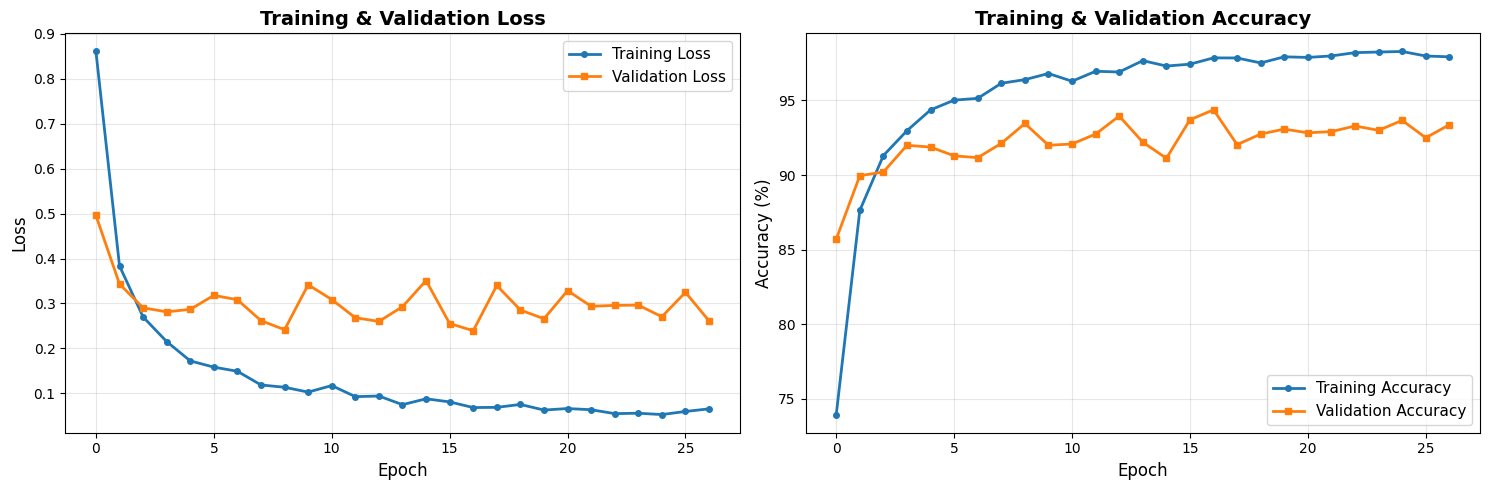

In [11]:
# Plot Training & Validation Loss and Accuracy
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Training Loss', linewidth=2, marker='o', markersize=4)
axes[0].plot(history['val_loss'], label='Validation Loss', linewidth=2, marker='s', markersize=4)
axes[0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Training Accuracy', linewidth=2, marker='o', markersize=4)
axes[1].plot(history['val_acc'], label='Validation Accuracy', linewidth=2, marker='s', markersize=4)
axes[1].set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Load Model and Test

## Sample Predictions Visualization

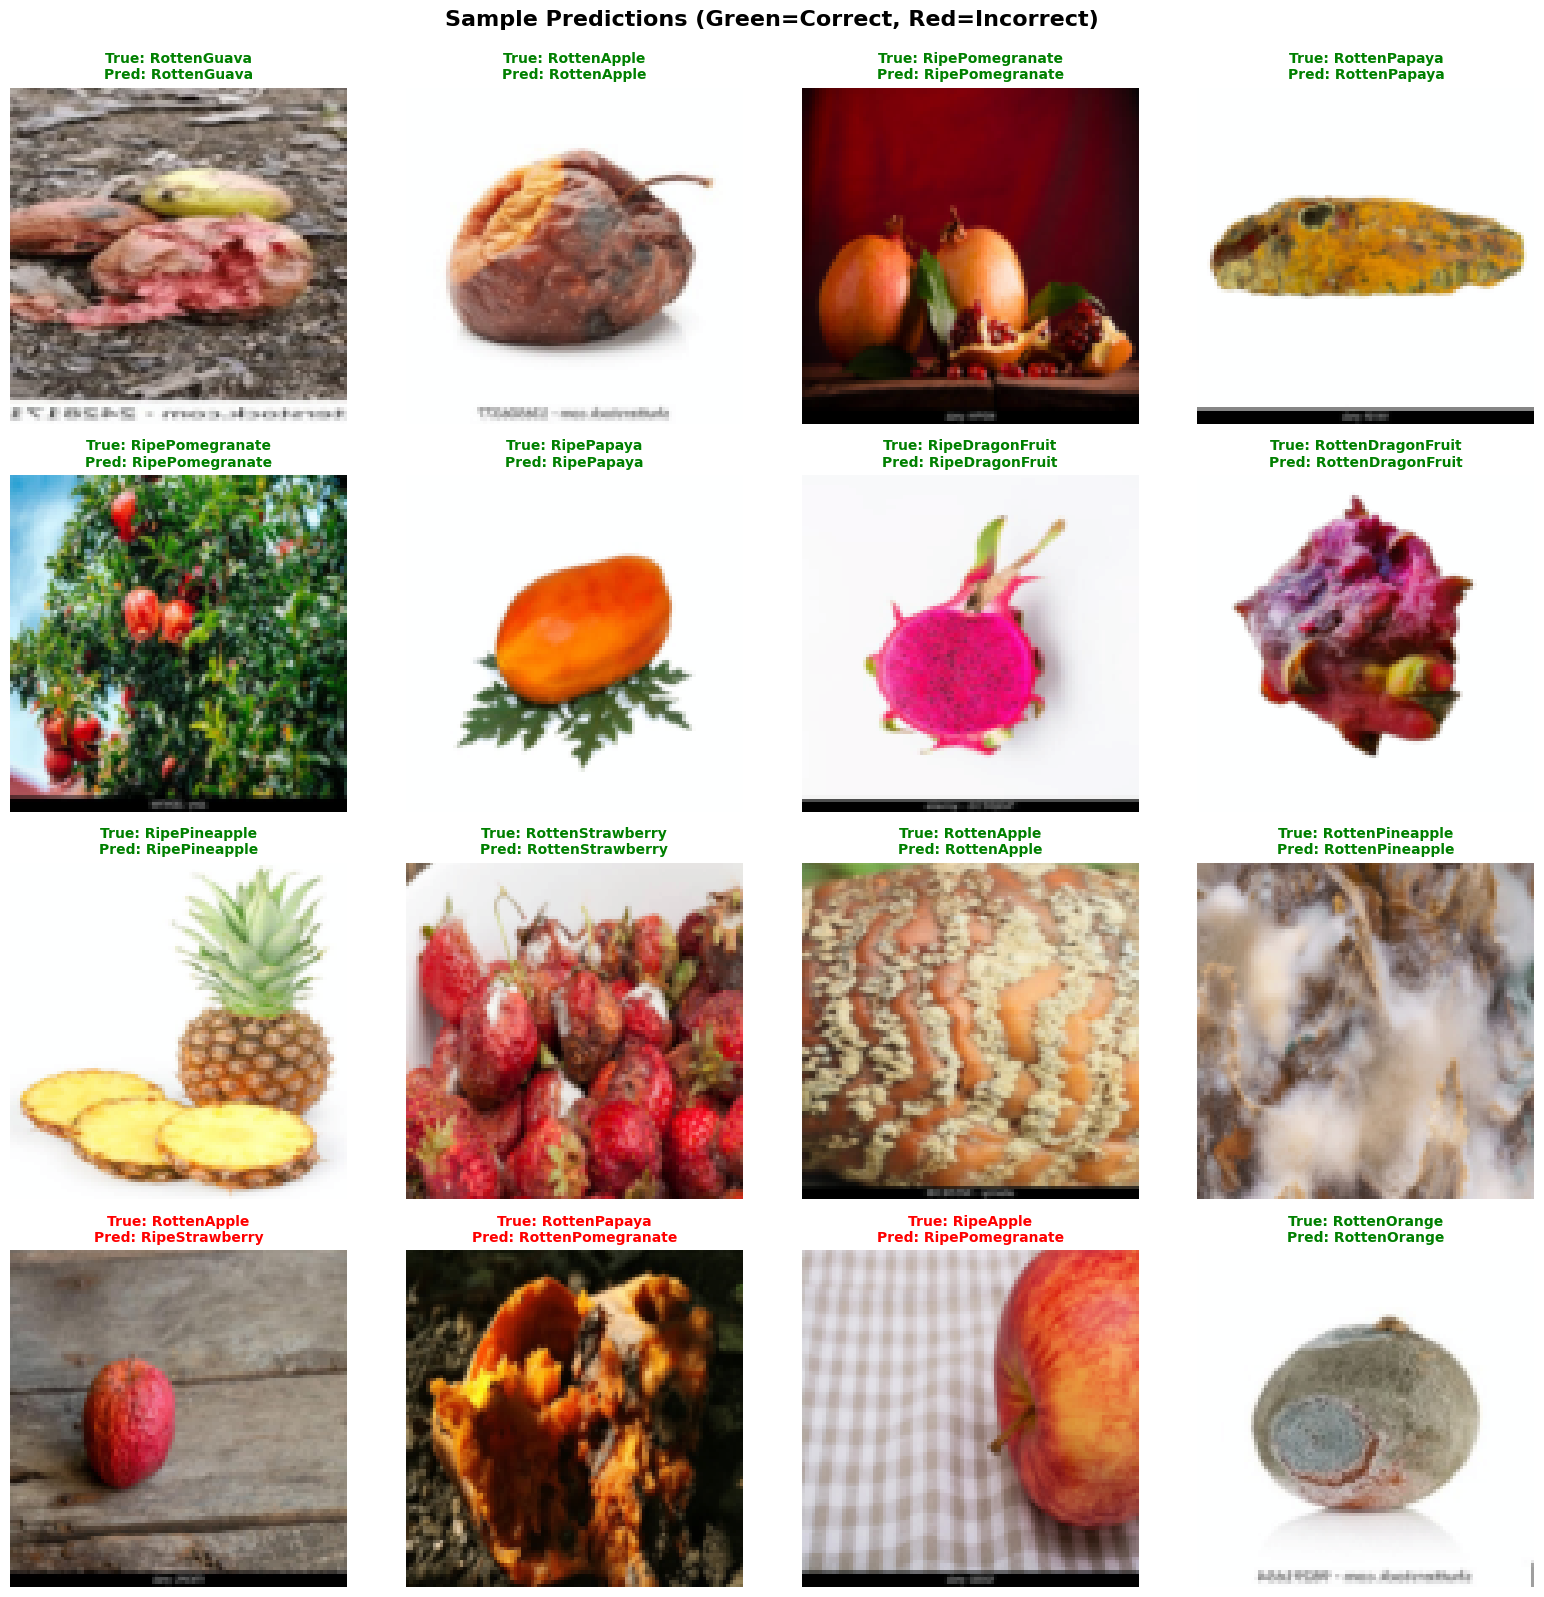

In [12]:
# Display sample predictions
num_samples = 16
indices = np.random.choice(len(test_images), num_samples, replace=False)

fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.ravel()

# Denormalize function
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

for idx, ax_idx in enumerate(indices):
    img = test_images[ax_idx]
    # Denormalize
    img = img.transpose(1, 2, 0)
    img = std * img + mean
    img = np.clip(img, 0, 1)

    pred_label = train_data.classes[predictions[ax_idx]]
    true_label = train_data.classes[true_labels[ax_idx]]

    axes[idx].imshow(img)
    axes[idx].axis('off')

    # Color code: green for correct, red for incorrect
    color = 'green' if pred_label == true_label else 'red'
    axes[idx].set_title(f'True: {true_label}\nPred: {pred_label}',
                        fontsize=10, color=color, fontweight='bold')

plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()